In [50]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import warnings
from sklearn.metrics import accuracy_score
from random import randrange
import pickle
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


In [51]:
def trait_simulation_oneloci(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    loci =random.randint(0,loci_m-1)
    print(loci)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G,samples_n,loci_m

In [52]:
G_oneloci, samples_n,loci_m = trait_simulation_oneloci(1000,20,.9,.1)

14


In [57]:
#split data into test and train
X = G_oneloci[:,0:len(G_oneloci[0])-1]

#last column is the appended Y vector we predicted
y = G_oneloci[:,len(G_oneloci[0])-1]

#split the data, 70% training
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [60]:
# torch can only train on Variable, so convert them to Variable
# wrap them in Variable
x = torch.from_numpy(x_train).float()
x_test_tensor = torch.from_numpy(x_test).float()
y = torch.from_numpy(y_train).float()
y = y.reshape(len(y),1)

net = torch.nn.Sequential(
        torch.nn.Linear(20, 256),
        torch.nn.ReLU(),
        torch.nn.Dropout(.25),
        torch.nn.Linear(256, 1),
        torch.nn.ReLU(),
        torch.nn.Dropout(.25)
    )
optimizer = torch.optim.Adam(net.parameters())
# loss_func = torch.nn.L1Loss()  # this is for regression mean squared loss
loss_func = torch.nn.MSELoss()
# train the network
for t in range(200):
  
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    

In [61]:
e = shap.DeepExplainer(net, x)
shap_values = e.shap_values(x_test_tensor)

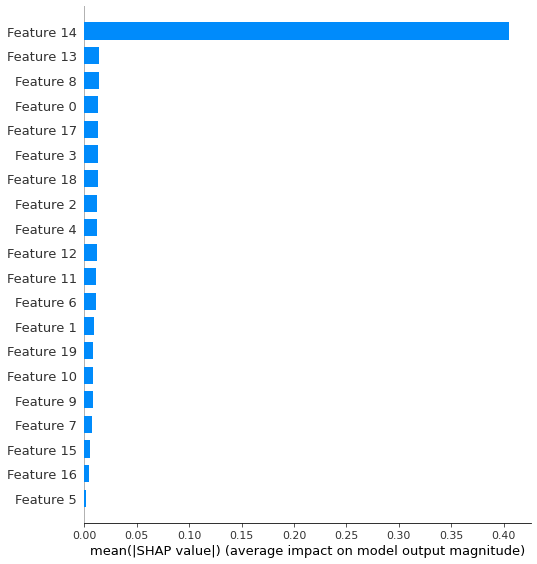

In [62]:
shap.summary_plot(shap_values, x, plot_type="bar")